In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import pymc as pm
import arviz as az

import sys, os
sys.path.insert(1, '../src')
from bayesian_change_point_model import BayesianChangePointModel

WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [2]:
df = pd.read_csv('../data/BrentOilPrices.csv')
df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=True)
df = df.set_index('Date').sort_index()
df['Price'] = df['Price'].ffill()
df['Log_Return'] = np.log(df['Price'] / df['Price'].shift(1))

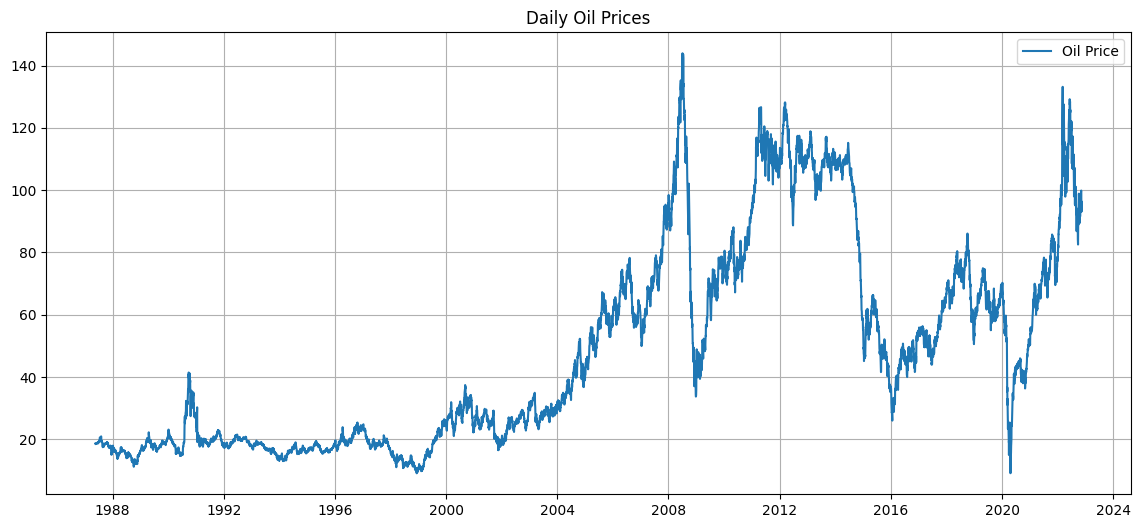

In [3]:
plt.figure(figsize=(14, 6))
plt.plot(df["Price"], label="Oil Price")
plt.title("Daily Oil Prices")
plt.legend()
plt.grid(True)
plt.show()

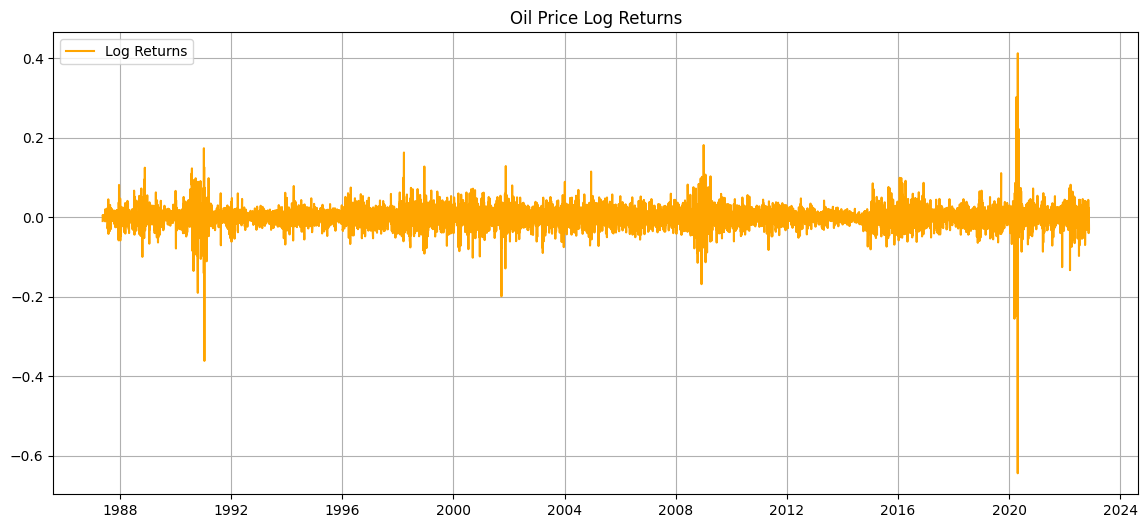

In [4]:
plt.figure(figsize=(14, 6))
plt.plot(df["Log_Return"], label="Log Returns", color="orange")
plt.title("Oil Price Log Returns")
plt.legend()
plt.grid(True)
plt.show()

In [5]:
result = adfuller(df["Log_Return"].dropna())
print(f"ADF Statistic: {result[0]:.3f}")
print(f"p-value: {result[1]:.3f}")

ADF Statistic: -16.427
p-value: 0.000


In [6]:
model_path = '../models/'
bcp = BayesianChangePointModel()
if not os.path.exists(os.path.join(model_path, 'trace.pickle')):
    print("Model trace not found. Running the model...")
    # Initialize and run the model
    bcp.create_model(df["Log_Return"])
    bcp.fit()
    bcp.save("../models")
else:
    print("Loading existing model trace...")
    bcp.load(file_prefix=model_path)

Loading existing model trace...


In [7]:
print(bcp.tau)

5386


In [9]:
tau_date = df.iloc[bcp.tau]
print(f"Estimated Change Point: {tau_date}")

Estimated Change Point: Price         126.860000
Log_Return     -0.002519
Name: 2008-07-23 00:00:00, dtype: float64


In [10]:
print(bcp.trace.values)

<bound method InferenceData.values of Inference data with groups:
	> posterior
	> sample_stats
	> observed_data>


<Figure size 700x700 with 0 Axes>

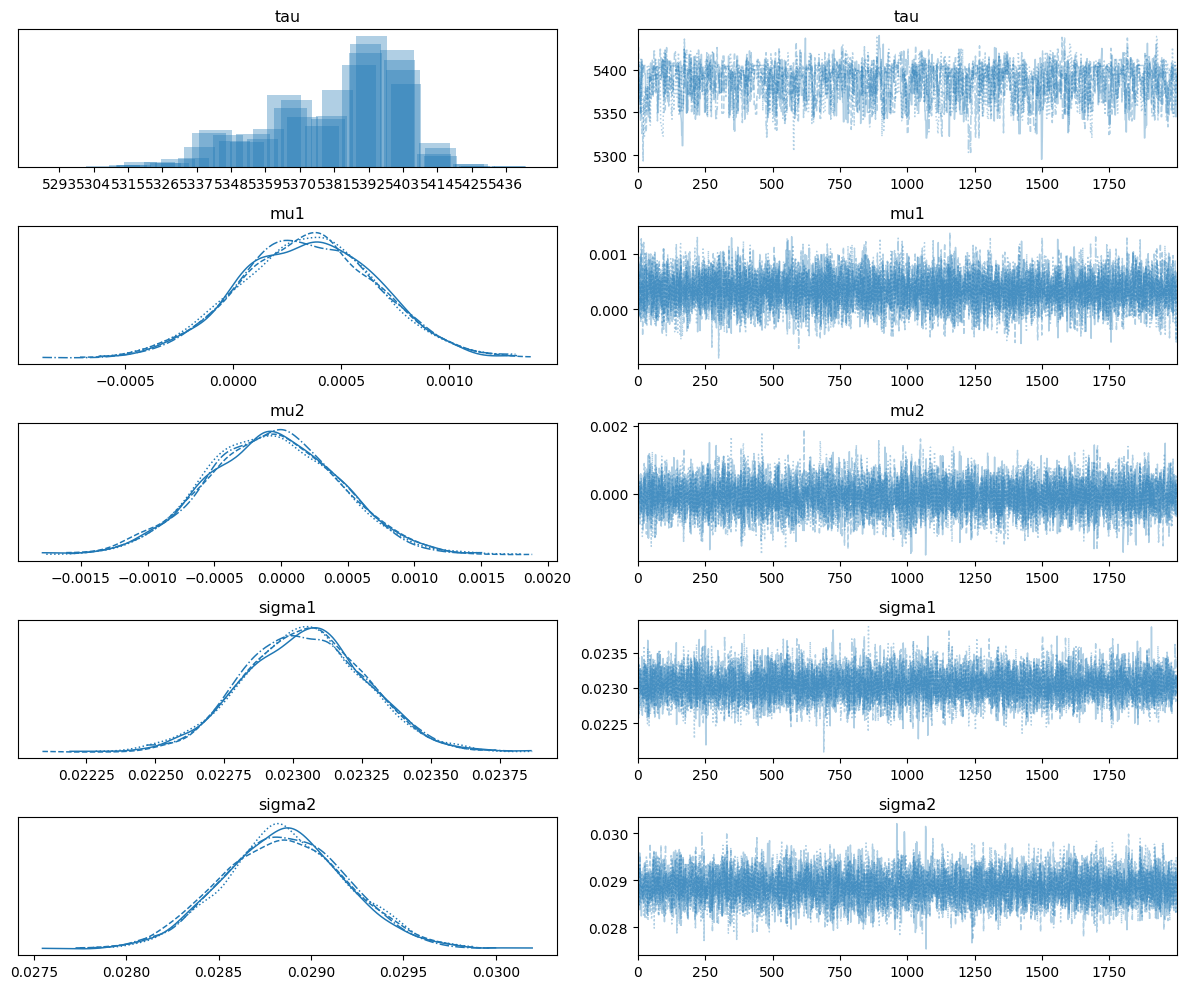

In [11]:
plt.figure(figsize=(7, 7))
az.plot_trace(bcp.trace)
plt.tight_layout()

In [16]:
print(bcp.trace.posterior["tau"])

<xarray.DataArray 'tau' (chain: 4, draw: 2000)> Size: 64kB
array([[5327, 5358, 5363, ..., 5345, 5345, 5394],
       [5404, 5404, 5404, ..., 5383, 5396, 5396],
       [5393, 5429, 5426, ..., 5405, 5405, 5405],
       [5399, 5393, 5375, ..., 5403, 5403, 5380]], shape=(4, 2000))
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 16kB 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999


In [29]:
from collections import Counter
def top_change_points(trace, n=10):
    # Flatten all tau samples from all chains and draws
    tau_samples = bcp.trace.posterior["tau"].values.flatten()

    # Count occurrences of each change point index
    tau_counts = Counter(tau_samples)

    # Get the 10 most common change point indices and their counts
    top_taus = tau_counts.most_common(n)

    return top_taus

In [26]:
 # Flatten all tau samples from all chains and draws
tau_samples = bcp.trace.posterior["tau"].values.flatten()

# Optionally, get the corresponding dates
tau_dates = df.index[tau_samples]

# Count occurrences of each change point index
tau_counts = Counter(tau_samples)

top_taus = tau_counts.most_common(10)

In [27]:
print(top_taus)

[(np.int64(5405), 493), (np.int64(5404), 349), (np.int64(5403), 258), (np.int64(5402), 239), (np.int64(5393), 239), (np.int64(5401), 218), (np.int64(5392), 208), (np.int64(5399), 204), (np.int64(5395), 180), (np.int64(5396), 180)]


In [28]:
def save_change_points():
        # Flatten all tau samples from all chains and draws
        tau_samples = bcp.trace.posterior["tau"].values.flatten()

        # Optionally, get the corresponding dates
        tau_dates = df.index[tau_samples]

        # Save both index and date to a DataFrame
        change_points_df = pd.DataFrame({
            "tau_index": tau_samples,
            "tau_date": tau_dates
        })

        counts = change_points_df.value_counts(subset=["tau_index", "tau_date"]).reset_index(name="count")
        # Save to CSV
        counts.to_csv("../data/change_point_index_date_counts.csv", index=False)

save_change_points()

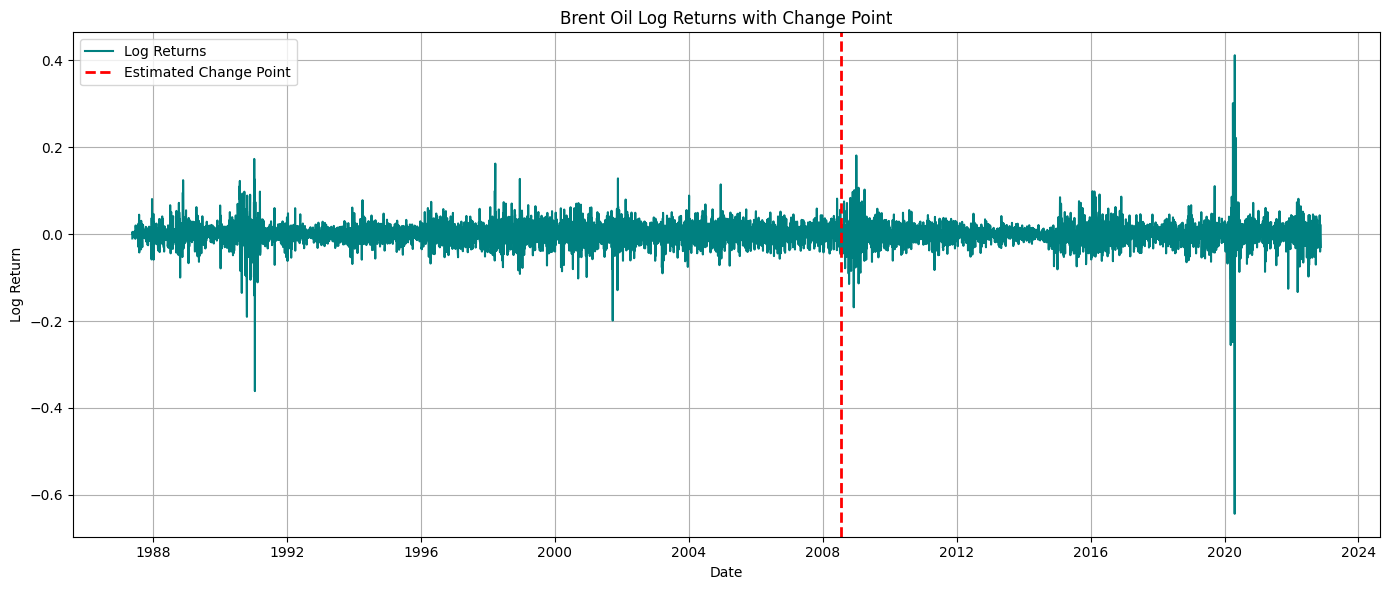

In [13]:
# Plot time series of log returns with change point
plt.figure(figsize=(14, 6))
plt.plot(df["Log_Return"], label="Log Returns", color="teal")

# Get change point index (use mean or median if array)
tau_idx = int(np.round(np.mean(bcp.tau)))  # or np.median(bcp.tau)
plt.axvline(df.index[tau_idx], color="red", linestyle="--", linewidth=2, label="Estimated Change Point")

plt.title("Brent Oil Log Returns with Change Point")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()